In [26]:
#import necessary libraries
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#import sklearn modules
from sklearn.compose import ColumnTransformer # for preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder # for scaling and encoding
from sklearn.model_selection import train_test_split # for splitting data
#import custom module for outlier removal
import sys
sys.path.append('../src')
from RemoveOutliers import remove_outliers

In [27]:
#Load the cleaned data
df_cleaned = pd.read_csv("../data/cleaned_data.csv")

In [28]:
#display the first few rows of the dataframe
df_cleaned.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,683.00,Germany,Male,49.00,7.00,123837.86,2.00,1.00,1.00,138700.75,1
1,608.00,France,Female,30.00,10.00,0.00,2.00,1.00,1.00,146723.72,0
2,539.00,France,Female,32.00,8.00,0.00,1.00,1.00,1.00,94873.60,0
3,530.00,Spain,Female,39.00,8.00,0.00,2.00,0.00,0.00,177896.93,0
4,613.00,France,Female,45.00,10.00,0.00,2.00,1.00,1.00,116748.14,0


In [29]:
#display the shape of the dataframe
df_cleaned.shape

(15000, 11)

In [30]:
#separate numerical and categorical variables
num_var = df_cleaned.select_dtypes(include=['int64', 'float64'])
cat_var = df_cleaned.select_dtypes(include=['object','category'])

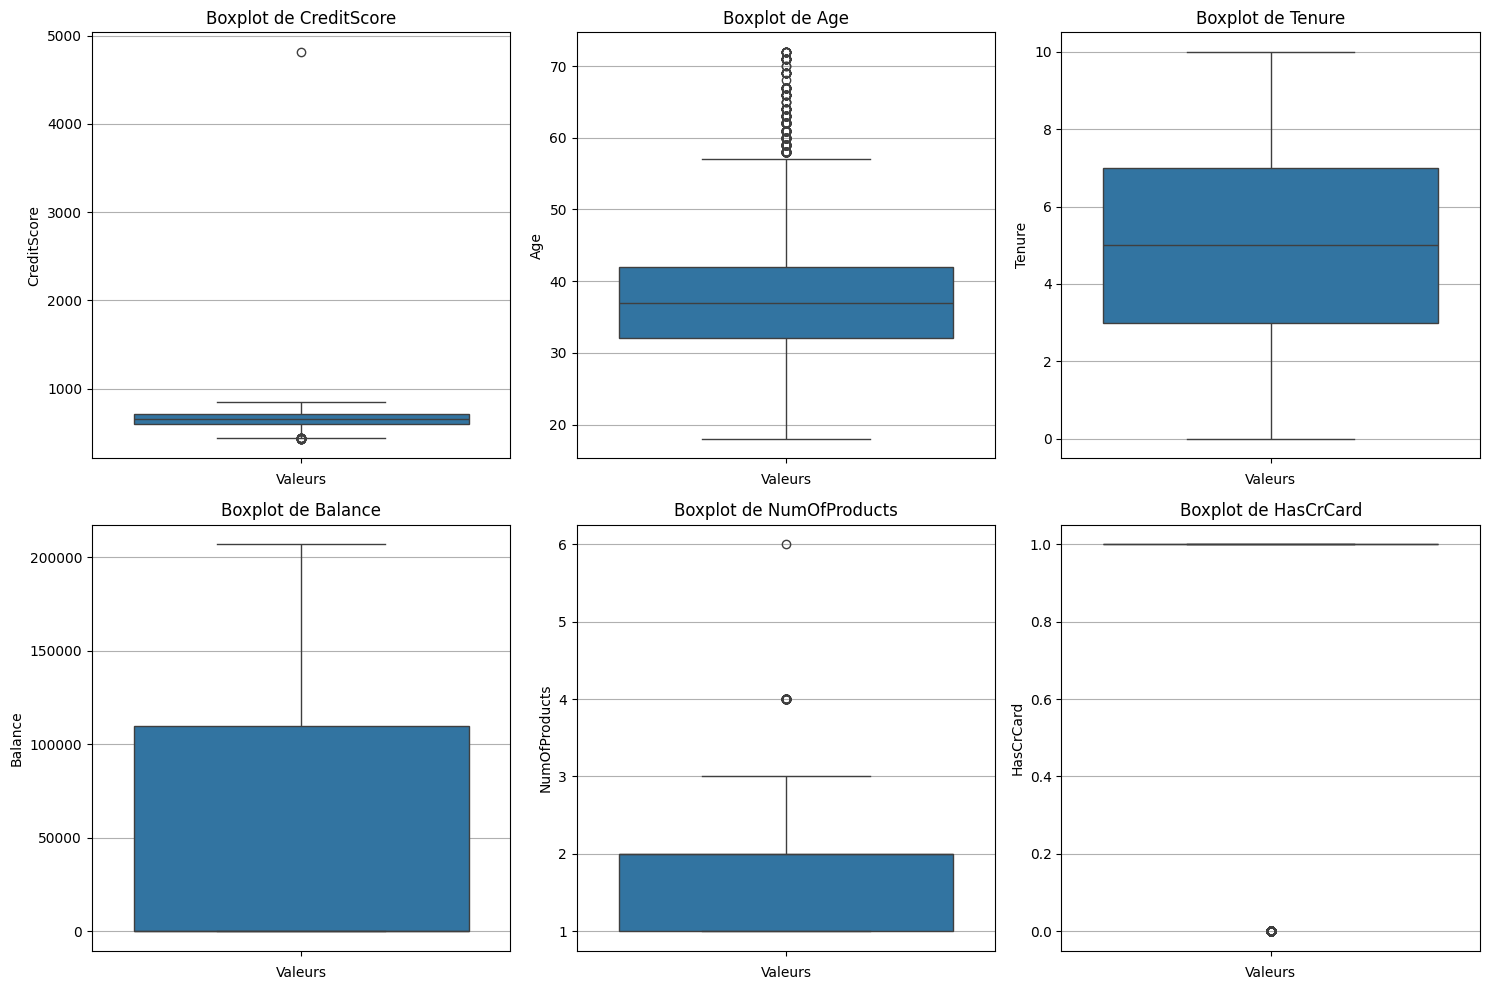

In [31]:
# Boxplot des variables
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, column in zip(axes.flatten(), num_var.columns):
    sns.boxplot(y=df_cleaned[column], ax=ax) 
    ax.set_title(f"Boxplot de {column}")
    ax.set_xlabel("Valeurs")
    ax.grid(axis='y')

plt.tight_layout()
plt.show()

In [32]:
df_cleaned['Exited'].value_counts()

Exited
0    12010
1     2990
Name: count, dtype: int64

In [33]:
df_cleaned.shape

(15000, 11)

In [34]:
df_cleaned_without_outliers = remove_outliers(df_cleaned, num_var.columns)

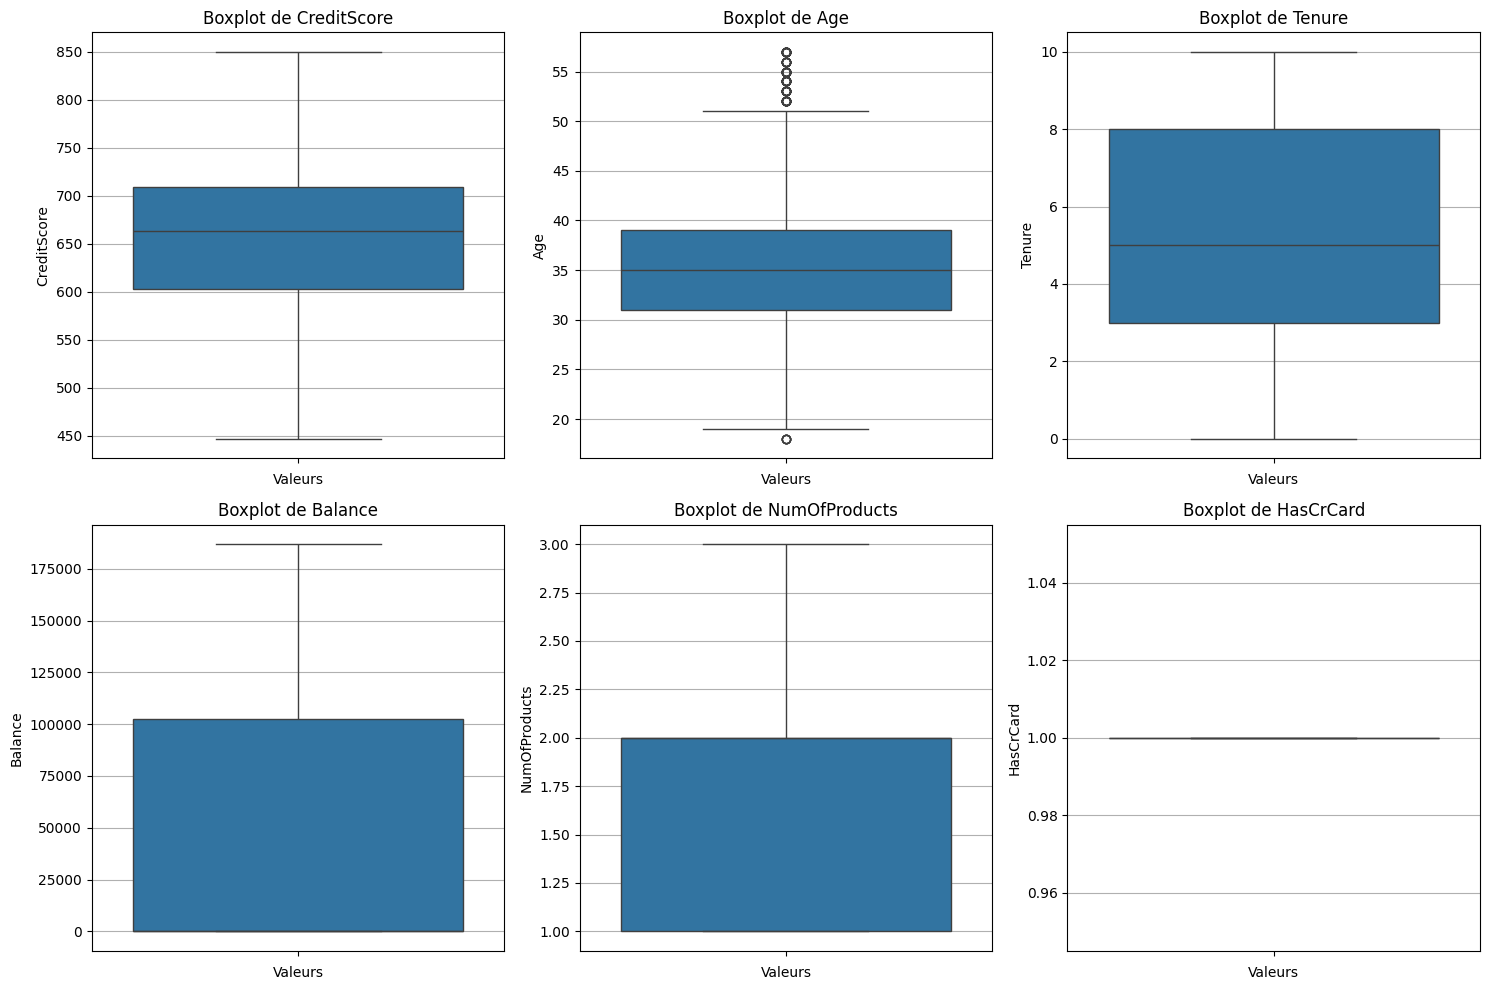

In [35]:
# Boxplot des variables
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, column in zip(axes.flatten(), num_var.columns):
    sns.boxplot(y=df_cleaned_without_outliers[column], ax=ax) 
    ax.set_title(f"Boxplot de {column}")
    ax.set_xlabel("Valeurs")
    ax.grid(axis='y')

plt.tight_layout()
plt.show()

---
Feature Engineering
---

Afin de mieux capturer les comportements clients et améliorer la performance prédictive de nos modèles, nous avons créé un ensemble de **variables dérivées** combinant indicateurs financiers, démographiques et comportementaux. Ces features visent à refléter le **niveau d’engagement**, la **stabilité financière** et la **relation client-banque**, tous des facteurs clés dans la décision de churn.


1. **`Ratio_Balance_Salary`** (`Balance / EstimatedSalary`)  
   → Proportion du solde bancaire par rapport au salaire estimé.  
   Un ratio très faible peut indiquer un faible usage des services bancaires, signalant un risque accru de churn.

2. **`Ratio_Balance_Age`** (`Balance / Age`)  
   → Solde ajusté à l’âge du client.  
   Un ratio bas chez les clients âgés peut refléter un désengagement progressif.

3. **`Ratio_Salary_Age`** (`EstimatedSalary / Age`)  
   → Salaire estimé relativement à l’âge.  
   Un faible ratio peut suggérer une instabilité financière ou un désintérêt pour les offres premium.

4. **`Engagement_Score`** (`IsActiveMember + NumOfProducts + HasCrCard`)  
   → Score synthétique d’engagement client (0 à 3).  
   Plus le score est élevé, plus le client est intégré à l’écosystème bancaire → faible probabilité de churn.

5. **`Ratio_Products_Age`** (`NumOfProducts / Age`)  
   → Nombre de produits détenus par année d’âge.  
   Un ratio faible peut indiquer un manque d’intérêt ou une relation superficielle avec la banque.

6. **`Relative_Salary`** (`EstimatedSalary / Moyenne(EstimatedSalary) par pays`)  
   → Salaire du client comparé à la moyenne nationale.  
   Les clients en dessous de la moyenne locale sont souvent plus sensibles aux frais et moins fidèles.

7. **`Ratio_CreditScore_Age`** (`CreditScore / Age`)  
   → Score de crédit ajusté à l’âge.  
   Un ratio bas peut signaler un historique de crédit limité ou un risque perçu plus élevé.

8. **`Zero_Balance_HasCrCard`** (`Balance == 0 & HasCrCard == 1`)  
   → Client détenteur d’une carte de crédit mais avec un solde nul.  
   Fort indicateur de désengagement actif → risque élevé de churn.

9. **`Low_Balance_Active`** (`Balance < Moyenne(Balance) & IsActiveMember == 1`)  
   → Client actif mais avec un solde inférieur à la moyenne.  
   Peut traduire une insatisfaction ou un usage minimal malgré l’activité déclarée.

10. **`Active_HasCrCard`** (`IsActiveMember * HasCrCard`)  
    → Interaction binaire : client à la fois actif **et** détenteur d’une carte de crédit.  
    Ces clients utilisent des services clés → plus fidèles.

11. **`Log_Salary`** (`np.log1p(EstimatedSalary)`)  
    → Transformation logarithmique du salaire estimé.  
    Réduit l’impact des valeurs extrêmes et linéarise la relation entre salaire et churn.

In [36]:
# 1. Ratio du solde par rapport au salaire estimé
df_cleaned['Ratio_Balance_Salary'] = df_cleaned['Balance'] / df_cleaned['EstimatedSalary']

# 2. Ratio du solde par l'âge
df_cleaned['Ratio_Balance_Age'] = df_cleaned['Balance'] / df_cleaned['Age']

# 3. Ratio du salaire par l'âge
df_cleaned['Ratio_Salary_Age'] = df_cleaned['EstimatedSalary'] / df_cleaned['Age']

# 4. Score d'engagement
df_cleaned['Engagement_Score'] = df_cleaned['IsActiveMember'] + df_cleaned['NumOfProducts'] + df_cleaned['HasCrCard']

# 5. Ratio Produits/Age
df_cleaned['Ratio_Products_Age'] = df_cleaned['NumOfProducts'] / df_cleaned['Age']

# 6. Score de revenu relatif par pays
df_cleaned['Relative_Salary'] = df_cleaned['EstimatedSalary'] / df_cleaned.groupby('Geography')['EstimatedSalary'].transform('mean')

# 7. Ratio Crédit/Age
df_cleaned['Ratio_CreditScore_Age'] = df_cleaned['CreditScore'] / df_cleaned['Age']

# 8. Solde nul avec une carte de crédit
df_cleaned['Zero_Balance_HasCrCard'] = (df_cleaned['Balance'] == 0) & (df_cleaned['HasCrCard'] == 1)

# 9. Client actif avec faible solde
df_cleaned['Low_Balance_Active'] = (df_cleaned['Balance'] < df_cleaned['Balance'].mean()) & (df_cleaned['IsActiveMember'] == 1)

# 10. Possède une carte et est actif
df_cleaned['Active_HasCrCard'] = df_cleaned['IsActiveMember'] * df_cleaned['HasCrCard']

# 11. Logarithme du salaire estimé
df_cleaned['Log_Salary'] = np.log1p(df_cleaned['EstimatedSalary'])

In [37]:
#display the first few rows of the dataframe after feature engineering
df_cleaned.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Ratio_Balance_Age,Ratio_Salary_Age,Engagement_Score,Ratio_Products_Age,Relative_Salary,Ratio_CreditScore_Age,Zero_Balance_HasCrCard,Low_Balance_Active,Active_HasCrCard,Log_Salary
0,683.00,Germany,Male,49.00,7.00,123837.86,2.00,1.00,1.00,138700.75,...,2527.30,2830.63,4.00,0.04,1.16,13.94,False,False,1.00,11.84
1,608.00,France,Female,30.00,10.00,0.00,2.00,1.00,1.00,146723.72,...,0.00,4890.79,4.00,0.07,1.25,20.27,True,True,1.00,11.90
2,539.00,France,Female,32.00,8.00,0.00,1.00,1.00,1.00,94873.60,...,0.00,2964.80,3.00,0.03,0.81,16.84,True,True,1.00,11.46
3,530.00,Spain,Female,39.00,8.00,0.00,2.00,0.00,0.00,177896.93,...,0.00,4561.46,2.00,0.05,1.51,13.59,False,False,0.00,12.09
4,613.00,France,Female,45.00,10.00,0.00,2.00,1.00,1.00,116748.14,...,0.00,2594.40,4.00,0.04,0.99,13.62,True,True,1.00,11.67


---
Selected the potential model candidate
---

**LAZYPREDICT** 

In [38]:
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import recall_score

In [42]:
# Séparer les caractéristiques et la cible
X = df_cleaned.drop('Exited', axis=1)
y = df_cleaned['Exited']

# Diviser les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

# LazyClassifier 
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=recall_score)
models_par_defaut, predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models_par_defaut.columns)

# Les résultats
columns = ['F1 Score', 'recall_score', 'Time Taken']
filtered_models_par_defaut = models_par_defaut[columns]
display(filtered_models_par_defaut)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 2418, number of negative: 9582
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2497
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201500 -> initscore=-1.376946
[LightGBM] [Info] Start training from score -1.376946
Index(['Accuracy', 'Balanced Accuracy', 'ROC AUC', 'F1 Score', 'recall_score',
       'Time Taken'],
      dtype='object')


,F1 Score,recall_score,Time Taken
Model,,,
LGBMClassifier,0.88,0.65,0.20
XGBClassifier,0.88,0.65,0.18
AdaBoostClassifier,0.89,0.63,0.63
GaussianNB,0.84,0.72,0.04
NearestCentroid,0.80,0.80,0.04
RandomForestClassifier,0.88,0.62,1.60
ExtraTreesClassifier,0.88,0.62,0.75
BernoulliNB,0.83,0.70,0.04
SVC,0.88,0.58,2.23


* **Top Performance** : 
Les modèles de type Boosting (**LGBMClassifier** et **XGBClassifier**) dominent le classement avec un **Recall de 0.65**.

In [40]:
#save the preprocessed data
#df_cleaned.to_csv('../data/preprocessed_data.csv', index=False)